In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=26f47329ef3ddb907289379ede81e626efcfff4439d3e2694c8568a0005cea6a
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
import pyspark
import numpy as np # linear algebra
import pandas as pd # data processing

import os
import json
from pyspark.sql.functions import col, lead, concat_ws, to_timestamp, hour, count, explode, struct, lit, lag, min, max, first, last, rank, lower, regexp_replace, split, udf
from pyspark.sql.types import DataType, ArrayType, Row, StructType, StructField, FloatType, StringType
from pyspark.sql.window import Window
from pyspark.sql import types
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler



In [3]:
# conf = pyspark.SparkConf()
# sc = pyspark.SparkContext(conf = conf)
# spark = pyspark.SQLContext.getOrCreate(sc)
conf = pyspark.SparkConf()
conf.set('spark.driver.memory','8g')
x = pyspark.SparkContext(conf=conf).getOrCreate()
spark = pyspark.SQLContext.getOrCreate(x)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/23 01:13:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [4]:
df = spark.read.option("inferSchema", "true").option("header", "true").csv('/kaggle/input/google-2019-cluster-sample/borg_traces_data.csv', sep=',', multiLine = True)

In [5]:
%time
df.count()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


405894

In [6]:
df = df.withColumn("time", col("time"))

# Q1) How are the traces of requests distributed by cluster?

In [7]:
q1 = df.groupBy(col("cluster")).count().sort("cluster")

In [8]:
q1.show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|42713|
|      2|44417|
|      3|58783|
|      4|55502|
|      5|48657|
|      6|58531|
|      7|50360|
|      8|46931|
+-------+-----+



In [9]:
ans1Count = [row[0] for row in q1.select('count').collect()]


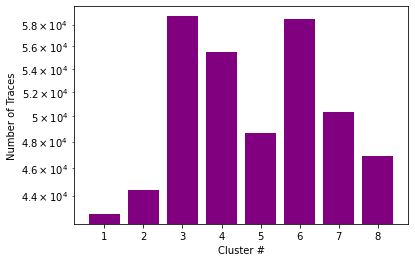

In [10]:
plt.bar(np.arange(1, len(ans1Count) + 1), ans1Count, color = 'purple', log = True)
plt.xlabel("Cluster #")
plt.ylabel("Number of Traces")
plt.show()

# Q2) How many parallel traces are running at each time stamp

In [11]:
columnNames = df.columns

In [12]:
df.select(col("time")).count()

405894

In [13]:
df.select(col("time")).dropna().count()

405894

In [14]:
dfq2 = df.select(col("time")).dropna()

In [15]:
dfq2.show(5)

+-------------+
|         time|
+-------------+
|            0|
|2517305308183|
| 195684022913|
|            0|
|1810627494172|
+-------------+
only showing top 5 rows



In [16]:
dfq2 = dfq2.filter(col("time") >= 600*(10**6))

In [17]:
dfq2 = dfq2.withColumn("offset", lit(600*(10**6)))

In [18]:
dfq2 = dfq2.withColumn("timeCorr", (col("time") - col("offset"))/10**6)   #### convertin to seconds from milli-seconds
dfq2.show()

+-------------+---------+--------------+
|         time|   offset|      timeCorr|
+-------------+---------+--------------+
|2517305308183|600000000|2516705.308183|
| 195684022913|600000000| 195084.022913|
|1810627494172|600000000|1810027.494172|
|1626744497194|600000000|1626144.497194|
| 130721370174|600000000| 130121.370174|
|2373350421416|600000000|2372750.421416|
|1970214287222|600000000|1969614.287222|
|2212203898561|600000000|2211603.898561|
|  36255576255|600000000|  35655.576255|
| 723622816016|600000000| 723022.816016|
| 204389347359|600000000| 203789.347359|
|1659671622423|600000000|1659071.622423|
| 365676977693|600000000| 365076.977693|
|1129358774407|600000000|1128758.774407|
|1584163989226|600000000|1583563.989226|
| 296066697739|600000000| 295466.697739|
| 116367066181|600000000| 115767.066181|
|2220916046503|600000000|2220316.046503|
|1892214193263|600000000|1891614.193263|
| 104045399544|600000000| 103445.399544|
+-------------+---------+--------------+
only showing top

In [19]:
q2 = dfq2.drop("time", "offset")

In [20]:
q2.show(5)

+--------------+
|      timeCorr|
+--------------+
|2516705.308183|
| 195084.022913|
|1810027.494172|
|1626144.497194|
| 130121.370174|
+--------------+
only showing top 5 rows



#### Converting to hours from seconds

In [21]:
q2 = q2.withColumn("hours", col("timeCorr")/3600)

In [22]:
q2.show(5)

+--------------+------------------+
|      timeCorr|             hours|
+--------------+------------------+
|2516705.308183| 699.0848078286111|
| 195084.022913| 54.19000636472222|
|1810027.494172| 502.7854150477778|
|1626144.497194|451.70680477611114|
| 130121.370174| 36.14482504833333|
+--------------+------------------+
only showing top 5 rows



In [23]:
q2 = q2.select(col("hours").cast("int"))

### Binning in 24 hour hour format

In [24]:
q2 = q2.withColumn("hourBin", col("hours")%24)

In [25]:
q2.show(5)

+-----+-------+
|hours|hourBin|
+-----+-------+
|  699|      3|
|   54|      6|
|  502|     22|
|  451|     19|
|   36|     12|
+-----+-------+
only showing top 5 rows



In [26]:
ans2 = q2.drop("hours").groupBy("hourBin").count().sort("hourBin")

In [27]:
ans2.show(24)

+-------+-----+
|hourBin|count|
+-------+-----+
|      0|11562|
|      1|14826|
|      2|15796|
|      3|16031|
|      4|12963|
|      5|16145|
|      6|16033|
|      7|12618|
|      8|19711|
|      9|13180|
|     10|18690|
|     11|12818|
|     12|14512|
|     13|13751|
|     14|14337|
|     15|12851|
|     16|10878|
|     17|15404|
|     18|13477|
|     19|20083|
|     20|19445|
|     21| 9807|
|     22|12212|
|     23|12312|
+-------+-----+



In [28]:
ans2Count = [row[0] for row in ans2.select('count').collect()]

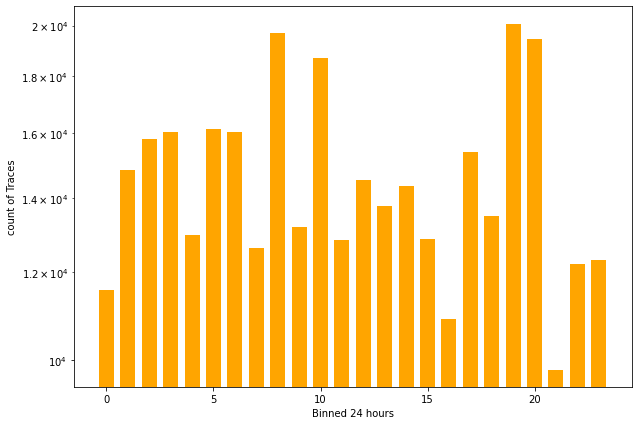

In [29]:
plt.figure(figsize = (10, 7))
plt.bar(np.arange(24), ans2Count, width = 0.7, bottom = 0, log = True, color = "orange")
plt.xlabel("Binned 24 hours")
plt.ylabel("count of Traces")
plt.show()

In [30]:
l = [row[0] for row in q2.drop("hourBin").groupBy("hours").count().sort("hours").select('count').collect()] 

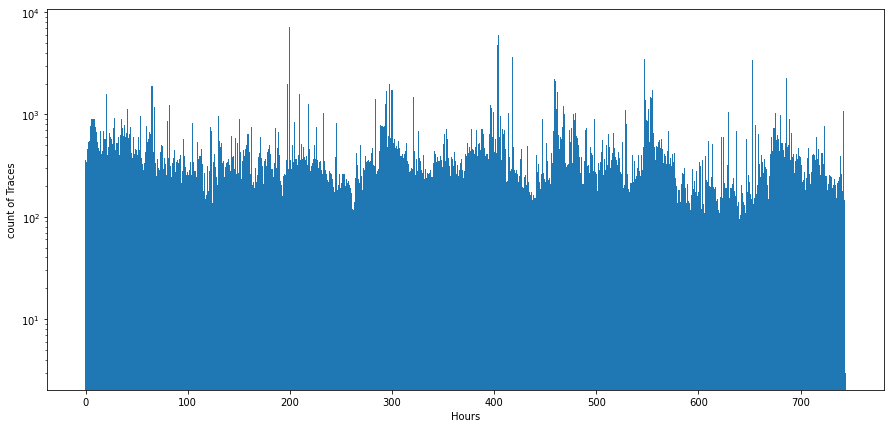

In [31]:
fig = plt.figure(figsize = (15, 7))
plt.bar(np.arange(len(l)), l, width = 1, log = True)
plt.xlabel("Hours")
plt.ylabel("count of Traces")
plt.show()

# Question 3 What is the distribution of different types of request loads across different clusters?

In [32]:
q3 = df.groupBy("cluster", "event").count()

In [33]:
q3 = q3.orderBy(col("cluster"), col("event"))

In [34]:
q3.show()

+-------+--------------+-----+
|cluster|         event|count|
+-------+--------------+-----+
|      1|        ENABLE| 4717|
|      1|         EVICT| 2515|
|      1|          FAIL| 9052|
|      1|        FINISH| 9915|
|      1|          KILL|   14|
|      1|          LOST| 9923|
|      1|      SCHEDULE| 6549|
|      1|UPDATE_PENDING|   28|
|      2|        ENABLE| 4834|
|      2|         EVICT|    6|
|      2|          FAIL| 9959|
|      2|        FINISH| 9584|
|      2|          KILL|    3|
|      2|          LOST|10041|
|      2|      SCHEDULE| 9990|
|      3|        ENABLE|11853|
|      3|         EVICT| 1616|
|      3|          FAIL|12710|
|      3|        FINISH|11538|
|      3|          KILL|  760|
+-------+--------------+-----+
only showing top 20 rows



In [35]:
eventNames = [i[0] for i in q3.select("event").collect()]

In [36]:
event_set = set(eventNames)
unique_event = list(event_set)

In [37]:
unique_event = sorted(unique_event)

In [38]:
q3_pandas = q3.toPandas()
cluster_list = list(q3_pandas["cluster"])
event_list = list(q3_pandas["event"])
count_list = list(q3_pandas["count"])

In [39]:
l = [[],[],[],[],[],[],[],[],[],[]]
cnt = 0
z = set(cluster_list)
for i in range(len(z)):
    for j in range(len(unique_event)):
        if unique_event[j] == event_list[0]:
            l[j].append(count_list[0])
            event_list.pop(0)
            count_list.pop(0)
            cluster_list.pop(0)
            cnt += 1
        else:
            l[j].append(0)    

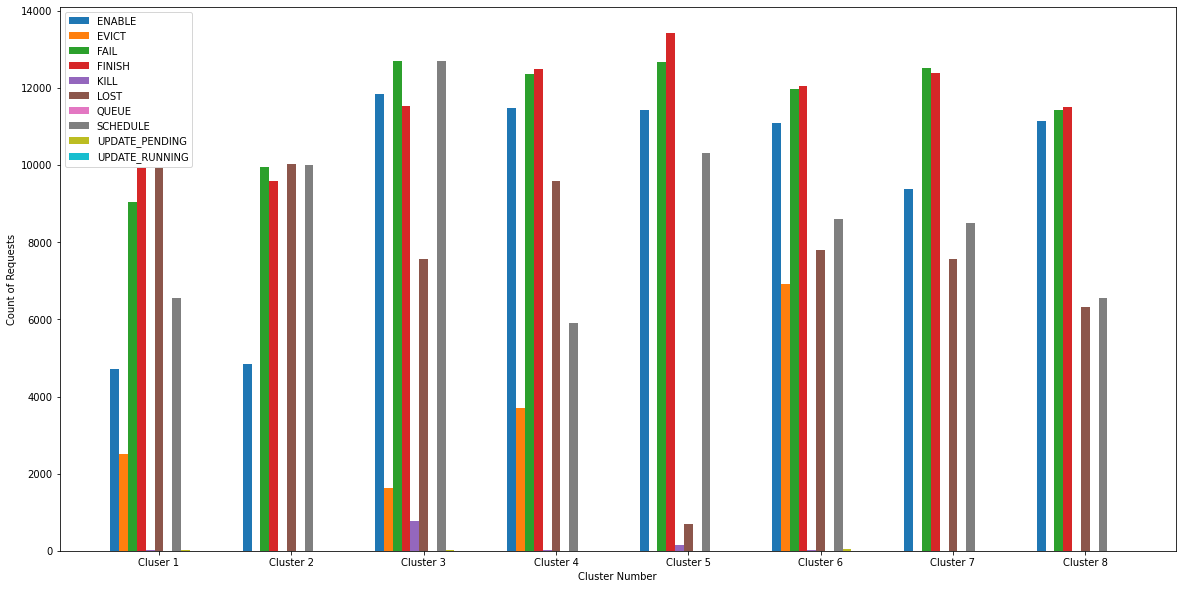

In [40]:
fig = plt.figure(figsize = (20, 10))
x = np.arange(0, 15*len(l[0]), 15)
width = 1
plt.bar(x-5, l[0], width)
plt.bar(x-4, l[1], width)
plt.bar(x-3, l[2], width)
plt.bar(x-2, l[3], width)
plt.bar(x-1, l[4], width)
plt.bar(x, l[5], width)
plt.bar(x+1, l[6], width)
plt.bar(x+2, l[7], width)
plt.bar(x+3, l[8], width)
plt.bar(x+4, l[9], width)
plt.xticks(x, ["Cluser 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8"])
plt.xlabel("Cluster Number")
plt.ylabel("Count of Requests")
plt.legend(unique_event)
plt.show()

### Q4) What is the average assigned memory to either failed or not failed jobs and requests on each cluster?

In [41]:
data = spark.read.option("inferSchema", "true").option("header", "true").csv('/kaggle/input/google-2019-cluster-sample/borg_traces_data.csv', sep=',', multiLine = True)
d4 = data.select(col("cluster"),col("assigned_memory"), col('failed'))
d4 = d4.groupBy(col("cluster"), col("failed")).avg("assigned_memory").sort(col("cluster"), col("failed"))

In [42]:
ans4 = [row[0] for row in d4.select('avg(assigned_memory)').collect()]


In [43]:
f = []
nf = []
for i in range(len(ans4)):
    if i%2!=0:
        f.append(ans4[i])
    else:
        nf.append(ans4[i])


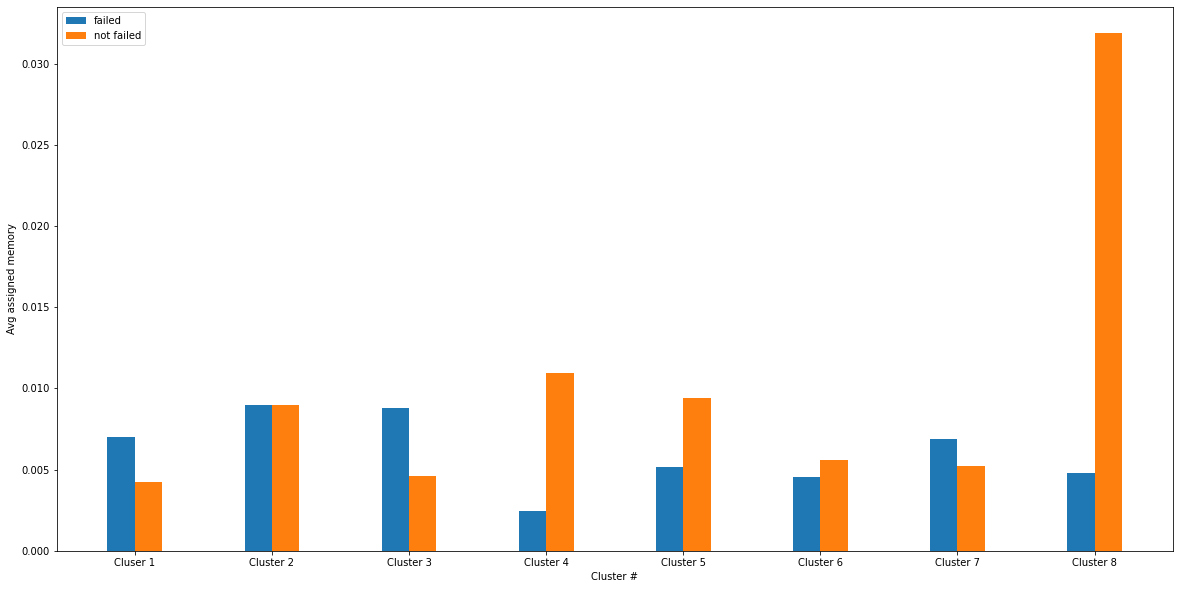

In [44]:
cluster = np.arange(1, 9)
fig = plt.figure(figsize = (20, 10))
x = np.arange(len(f))
width = 0.2

plt.bar(x-0.1, f, width)
plt.bar(x + 0.1, nf, width)

plt.xticks(x, ["Cluser 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8"])
plt.xlabel("Cluster #")
plt.ylabel("Avg assigned memory")
plt.legend(["failed", "not failed"])
plt.show()

### Q5) What is the average time taken for each event state?

In [45]:
d5a = data.groupBy(col("event")).count()
d5a.show()


+--------------+-----+
|         event|count|
+--------------+-----+
|        FINISH|92867|
|          KILL|  951|
|          FAIL|92678|
|          LOST|59515|
|UPDATE_PENDING|  111|
|UPDATE_RUNNING|    1|
|        ENABLE|75907|
|         EVICT|14756|
|         QUEUE|    4|
|      SCHEDULE|69104|
+--------------+-----+



In [46]:
d5 = data.select(col("event"),col("start_time"),col("end_time")).dropna()
d5 = d5.withColumn('duration_mins',(((col("end_time")-col("start_time"))/60000)))
d5 = d5.groupBy(col("event")).avg("duration_mins")
d5 = d5.withColumnRenamed("avg(duration_mins)","avg_duration")
d5 = d5.withColumnRenamed("event","event_b")
d5.show()



+--------------+------------------+
|       event_b|      avg_duration|
+--------------+------------------+
|        FINISH|3059.0477062179166|
|          KILL|2561.5842972309865|
|          FAIL| 4092.589575375846|
|          LOST|3245.0009801449646|
|UPDATE_PENDING|1814.4144144144152|
|UPDATE_RUNNING|            5000.0|
|        ENABLE|3914.2283759510055|
|         EVICT|1411.4066594379733|
|         QUEUE| 866.6666666666666|
|      SCHEDULE| 3707.664293431709|
+--------------+------------------+



In [47]:
joined = d5a.join(d5, d5a.event == d5.event_b, how = "left")
joined = joined.drop("event_b").withColumn("avg_duration_minutes", col("avg_duration")/col("count"))
joined.show()


+--------------+-----+------------------+--------------------+
|         event|count|      avg_duration|avg_duration_minutes|
+--------------+-----+------------------+--------------------+
|        FINISH|92867|3059.0477062179166| 0.03294009396467978|
|          KILL|  951|2561.5842972309865|  2.6935691874142864|
|          FAIL|92678| 4092.589575375846|0.044159234935754396|
|          LOST|59515|3245.0009801449646| 0.05452408603116802|
|UPDATE_PENDING|  111|1814.4144144144152|   16.34607580553527|
|UPDATE_RUNNING|    1|            5000.0|              5000.0|
|        ENABLE|75907|3914.2283759510055| 0.05156610557591534|
|         EVICT|14756|1411.4066594379733| 0.09564967873664769|
|         QUEUE|    4| 866.6666666666666|  216.66666666666666|
|      SCHEDULE|69104| 3707.664293431709|0.053653396235119666|
+--------------+-----+------------------+--------------------+



In [48]:
duration = [row[0] for row in joined.select("avg_duration_minutes").collect()]
event = [row[0] for row in joined.select("event").collect()]
e = []
d = []
for i, j in enumerate(sorted(zip(event, duration), key = lambda x: x[0])):
    e.append(j[0])
    d.append(j[1])
joined.show()


+--------------+-----+------------------+--------------------+
|         event|count|      avg_duration|avg_duration_minutes|
+--------------+-----+------------------+--------------------+
|        FINISH|92867|3059.0477062179166| 0.03294009396467978|
|          KILL|  951|2561.5842972309865|  2.6935691874142864|
|          FAIL|92678| 4092.589575375846|0.044159234935754396|
|          LOST|59515|3245.0009801449646| 0.05452408603116802|
|UPDATE_PENDING|  111|1814.4144144144152|   16.34607580553527|
|UPDATE_RUNNING|    1|            5000.0|              5000.0|
|        ENABLE|75907|3914.2283759510055| 0.05156610557591534|
|         EVICT|14756|1411.4066594379733| 0.09564967873664769|
|         QUEUE|    4| 866.6666666666666|  216.66666666666666|
|      SCHEDULE|69104| 3707.664293431709|0.053653396235119666|
+--------------+-----+------------------+--------------------+



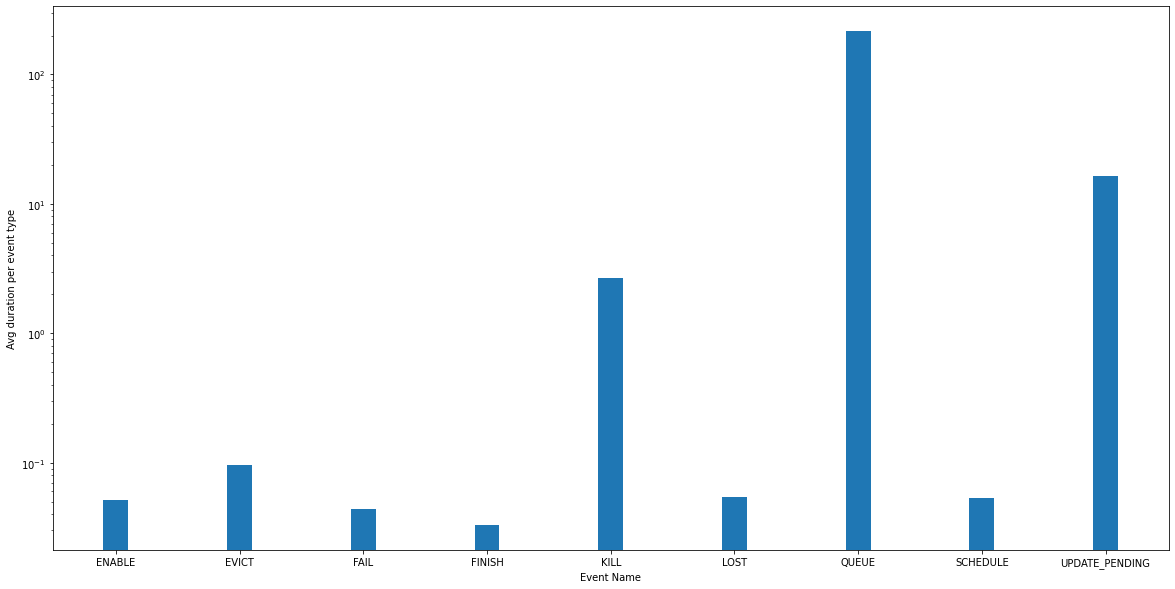

In [49]:
fig = plt.figure(figsize = (20, 10))
x = np.arange(len(e) - 1)
width = 0.2

plt.bar(x, d[: -1], width, log = True)

plt.xticks(x, e[:-1])
plt.xlabel("Event Name")
plt.ylabel("Avg duration per event type")
plt.show()

### Q6) How many are CPU intensive and how many are memory intensive requests?

In [50]:
df = spark.read.option("inferSchema", "true").option("header", "true").csv('/kaggle/input/google-2019-cluster-sample/borg_traces_data.csv', sep=',', multiLine = True)
q4 = df.drop('_c0')
q4.select('average_usage').show(2, truncate=False)
def convertToObject(in_str: Row):
    try:
        if in_str is not None:
            json_data = json.loads(in_str.replace('\'', '\"'))
            cpu_utilization = json_data['cpus']
            memory_utilization = json_data['memory']
            if cpu_utilization > memory_utilization:
                return "cpu"
            else:
                return "memory"
        return ""
    except Exception as e:
        print(e)
        return ""

convertUDF = udf(convertToObject, StringType())
df.select("resource_request").show(2)
df = df.withColumn("resource_request_converted",convertUDF("resource_request"))

+---------------------------------------------------------+
|average_usage                                            |
+---------------------------------------------------------+
|{'cpus': 0.00466156005859375, 'memory': 0.00592041015625}|
|{'cpus': 0.0, 'memory': 9.5367431640625e-07}             |
+---------------------------------------------------------+
only showing top 2 rows

+--------------------+
|    resource_request|
+--------------------+
|{'cpus': 0.020660...|
|{'cpus': 0.007240...|
+--------------------+
only showing top 2 rows



In [51]:
df.filter("resource_request_converted != ''").groupby('resource_request_converted').count().show()
df.select('resource_request').show(2, truncate=False)

+--------------------------+------+
|resource_request_converted| count|
+--------------------------+------+
|                       cpu|321702|
|                    memory| 83418|
+--------------------------+------+

+--------------------------------------------------------------+
|resource_request                                              |
+--------------------------------------------------------------+
|{'cpus': 0.020660400390625, 'memory': 0.014434814453125}      |
|{'cpus': 0.00724029541015625, 'memory': 0.0013027191162109375}|
+--------------------------------------------------------------+
only showing top 2 rows



In [52]:
resource_request_converted = df.filter("resource_request_converted != ''").groupby('resource_request_converted').count().collect()

In [53]:
labels = []
sizes = []
for curResource in resource_request_converted:
    labels.append(curResource[0])
    sizes.append(curResource[1])

print(labels)
print(sizes)

['cpu', 'memory']
[321702, 83418]


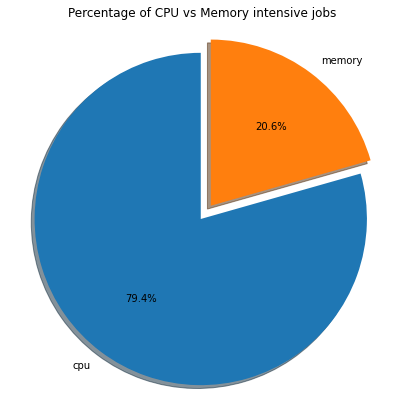

In [54]:
fig = plt.figure(figsize = (7, 7))
plt.title("Percentage of CPU vs Memory intensive jobs").set_color('black')
plt.pie(sizes, explode=(0.1,0),labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"black"}, )
plt.axis('equal')
plt.show()



### Q6) How does peak memory utilization vary with time on hourly basis?

In [55]:
df = spark.read.option("inferSchema", "true").option("header", "true").csv('/kaggle/input/google-2019-cluster-sample/borg_traces_data.csv', sep=',', multiLine = True)

In [56]:
day_time_group_df = df.drop('_c0')

In [57]:
day_time_group_df = day_time_group_df.filter(col("time") >= 600*(10**6))
day_time_group_df = day_time_group_df.withColumn("offset", lit(600*(10**6)))
day_time_group_df = day_time_group_df.withColumn("timeCorr", (col("time") - col("offset"))/10**6)   #### convertin to seconds from milli-seconds
day_time_group_df = day_time_group_df.drop("time", "offset")
day_time_group_df = day_time_group_df.withColumn("hours", col("timeCorr")/3600)
day_time_group_df = day_time_group_df.withColumn("hours", col("hours").cast("int"))

In [58]:
day_time_group_df = day_time_group_df.withColumn("hourBin", col("hours")%24)
day_time_group_df = day_time_group_df.withColumn("day", col("hours")/24)
day_time_group_df = day_time_group_df.withColumn("day", col("day").cast("int"))

In [59]:
def getMaxMemoryUsage(in_str: Row):
    try:
        if in_str is not None:
            json_data = json.loads(in_str.replace('\'', '\"'))
            memory_utilization = json_data['memory']
            return memory_utilization
        return -1
    except Exception as e:
        return -1

maxMemoryUsageUDF = udf(getMaxMemoryUsage, FloatType())

q5 = day_time_group_df.withColumn("max_memory_usage",maxMemoryUsageUDF("maximum_usage"))

In [60]:
max_usage_by_hour = q5.filter('max_memory_usage != -1').groupBy('hourBin').max('max_memory_usage').sort('hourBin')

In [61]:
max_usage_by_hour.show(24)

+-------+---------------------+
|hourBin|max(max_memory_usage)|
+-------+---------------------+
|      0|           0.18164062|
|      1|           0.22436523|
|      2|           0.22436523|
|      3|           0.22436523|
|      4|           0.22216797|
|      5|           0.22436523|
|      6|           0.18164062|
|      7|           0.22216797|
|      8|           0.22436523|
|      9|           0.22436523|
|     10|           0.22436523|
|     11|           0.22436523|
|     12|           0.22436523|
|     13|           0.22436523|
|     14|           0.22216797|
|     15|           0.22436523|
|     16|           0.22436523|
|     17|           0.18164062|
|     18|           0.18164062|
|     19|           0.18164062|
|     20|           0.22436523|
|     21|           0.18164062|
|     22|           0.18164062|
|     23|            0.1381836|
+-------+---------------------+



In [62]:
ans5_count = [y for (x,y) in max_usage_by_hour.collect()]

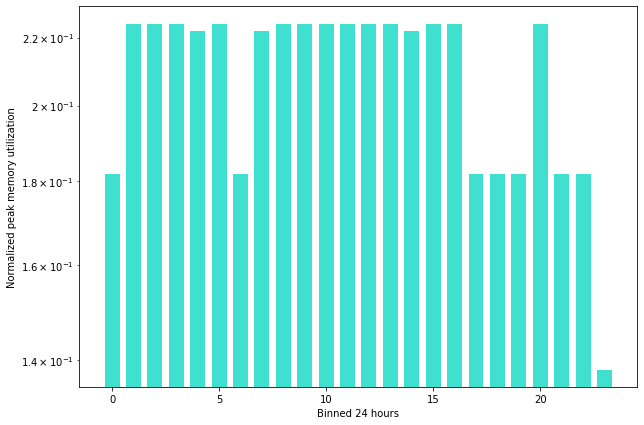

In [63]:
plt.figure(figsize = (10, 7))
plt.bar(np.arange(24), ans5_count, width = 0.7, bottom = 0, log = True, color = "turquoise")
plt.xlabel("Binned 24 hours")
plt.ylabel("Normalized peak memory utilization")
plt.show()

### Q7) How does the peak memory utilization vary on a day to day basis?

In [64]:
max_usage_by_day = q5.filter('max_memory_usage != -1 and day <= 31 and day >= 0').groupBy('day').max('max_memory_usage').sort('day')

In [65]:
max_usage_by_day.show(31)

+---+---------------------+
|day|max(max_memory_usage)|
+---+---------------------+
|  0|           0.18164062|
|  1|           0.18164062|
|  2|           0.18164062|
|  3|           0.12963867|
|  4|           0.18164062|
|  5|           0.22436523|
|  6|           0.22436523|
|  7|           0.22436523|
|  8|           0.22436523|
|  9|           0.22436523|
| 10|           0.22216797|
| 11|           0.22436523|
| 12|           0.22436523|
| 13|           0.22436523|
| 14|           0.18164062|
| 15|           0.12963867|
| 16|           0.22436523|
| 17|           0.22436523|
| 18|           0.12963867|
| 19|           0.22436523|
| 20|           0.18164062|
| 21|           0.18164062|
| 22|           0.22167969|
| 23|           0.12963867|
| 24|           0.22167969|
| 25|           0.16870117|
| 26|           0.22167969|
| 27|           0.16870117|
| 28|            0.1381836|
| 29|            0.1381836|
| 30|            0.1381836|
+---+---------------------+



In [66]:
ans5_count_by_day = [y for (x,y) in max_usage_by_day.collect()]

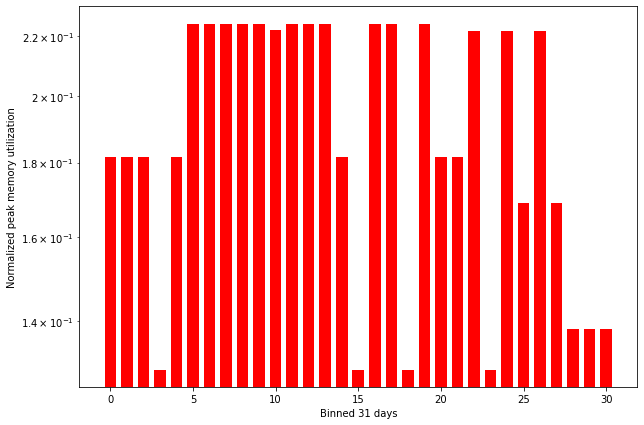

In [67]:
plt.figure(figsize = (10, 7))
plt.bar(np.arange(31), ans5_count_by_day, width = 0.7, bottom = 0, log = True, color = "red")
plt.xlabel("Binned 31 days")
plt.ylabel("Normalized peak memory utilization")
plt.show()

### Q8) How does the CPU peak capacities vary with time on an hourly basis?

In [68]:
def getMaxCPUUsage(in_str: Row):
    try:
        if in_str is not None:
            json_data = json.loads(in_str.replace('\'', '\"'))
            memory_utilization = json_data['cpus']
            return memory_utilization
        return -1
    except Exception as e:
        return -1

maxCPUUsageUDF = udf(getMaxCPUUsage, FloatType())

q6 = day_time_group_df.withColumn("max_cpu_usage",maxCPUUsageUDF("maximum_usage"))

In [69]:
def getMaxCPUUsage(in_str: Row):
    try:
        if in_str is not None:
            json_data = json.loads(in_str.replace('\'', '\"'))
            memory_utilization = json_data['cpus']
            return memory_utilization
        return -1
    except Exception as e:
        return -1

maxCPUUsageUDF = udf(getMaxCPUUsage, FloatType())

q6 = day_time_group_df.withColumn("max_cpu_usage",maxCPUUsageUDF("maximum_usage"))

In [70]:
max_cpu_usage_by_hour = q6.filter('max_cpu_usage != -1').groupBy('hourBin').max('max_cpu_usage').sort('hourBin')
max_cpu_usage_by_hour.show(24)

+-------+------------------+
|hourBin|max(max_cpu_usage)|
+-------+------------------+
|      0|         0.6611328|
|      1|         1.2714844|
|      2|         1.2539062|
|      3|         1.2714844|
|      4|         1.2714844|
|      5|         1.2714844|
|      6|         0.6611328|
|      7|         1.2714844|
|      8|         1.2714844|
|      9|         1.2539062|
|     10|         1.2714844|
|     11|         1.2714844|
|     12|         1.2539062|
|     13|         1.2226562|
|     14|         1.2714844|
|     15|         1.2226562|
|     16|         1.2539062|
|     17|         1.2246094|
|     18|         0.6611328|
|     19|         0.6611328|
|     20|         1.2226562|
|     21|         0.6611328|
|     22|         0.6611328|
|     23|        0.34472656|
+-------+------------------+



In [71]:
ans6_count = [y for (x,y) in max_cpu_usage_by_hour.collect()]

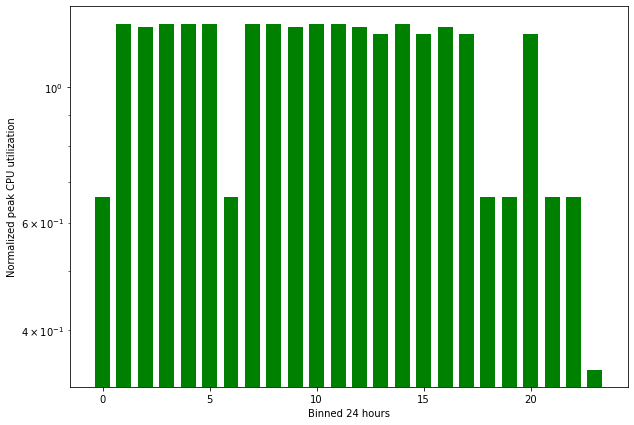

In [72]:
plt.figure(figsize = (10, 7))
plt.bar(np.arange(24), ans6_count, width = 0.7, bottom = 0, log = True, color = "green")
plt.xlabel("Binned 24 hours")
plt.ylabel("Normalized peak CPU utilization")
plt.show()

### Q9) How does the CPU peak capacities vary with time on a day to day basis?

In [73]:
max_usage_by_day = q6.filter('max_cpu_usage != -1 and day <= 31 and day >= 0').groupBy('day').max('max_cpu_usage').sort('day')
max_usage_by_day.show(31)

+---+------------------+
|day|max(max_cpu_usage)|
+---+------------------+
|  0|         0.6611328|
|  1|         1.2246094|
|  2|         0.6611328|
|  3|        0.61816406|
|  4|         0.6611328|
|  5|         1.2714844|
|  6|         1.2226562|
|  7|         1.2714844|
|  8|         1.2714844|
|  9|         1.2714844|
| 10|         1.2714844|
| 11|         1.2714844|
| 12|         1.2714844|
| 13|         1.2539062|
| 14|         0.6611328|
| 15|         0.3618164|
| 16|         1.2539062|
| 17|         1.2539062|
| 18|        0.34472656|
| 19|         1.2539062|
| 20|         0.6611328|
| 21|         0.6611328|
| 22|         1.1523438|
| 23|             0.375|
| 24|         1.1523438|
| 25|        0.20263672|
| 26|         1.1523438|
| 27|         0.3618164|
| 28|        0.43310547|
| 29|        0.42382812|
| 30|        0.43310547|
+---+------------------+



In [74]:
ans6_count_by_day = [y for (x,y) in max_usage_by_day.collect()]

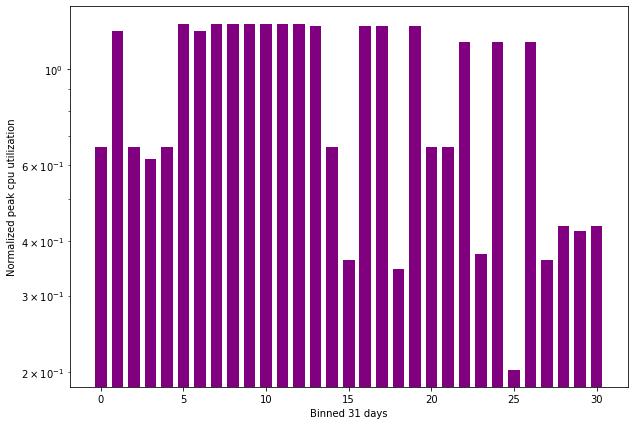

In [75]:
plt.figure(figsize = (10, 7))
plt.bar(np.arange(31), ans6_count_by_day, width = 0.7, bottom = 0, log = True, color = "purple")
plt.xlabel("Binned 31 days")
plt.ylabel("Normalized peak cpu utilization")
plt.show()

### Q10) Binary classification to see a request will fail or succeed in a cluster given its trace?

In [76]:
df = spark.read.option("inferSchema", "true").option("header", "true").csv('/kaggle/input/google-2019-cluster-sample/borg_traces_data.csv', sep=',', multiLine = True)

In [77]:
drop_cols = sorted(['_c0','collection_id','instance_events_type','alloc_collection_id','random_sample_usage', 'user', 'cycles_per_instruction',
                'start_after_collection_ids', 'machine_id', 'memory_accesses_per_instruction','resource_request','constraint', 'collection_name',
                'collection_logical_name', 'sample_rate', 'cpu_usage_distribution', 'instance_index', 'tail_cpu_usage_distribution'])

In [78]:
qML = df.drop(*drop_cols)

### TIME MANIPULATION :

In [79]:
qML = qML.withColumn("time_diff_hrs", ((col("end_time") - col("start_time"))/10**6)/3600).drop("start_time", "end_time") ### TIME DIFF IN HRS

In [80]:
qML = qML.filter(col("time") >= 600*(10**6)).withColumn("offset", lit(600*(10**6))).withColumn("timeCorr", (col("time") - col("offset"))/10**6).drop("time", "offset").withColumn("time", col("timeCorr")/3600).drop("timeCorr").withColumn("time", (col("time")%24).cast("int"))

In [81]:
qML = qML.withColumn("vertical_scaling", (col("vertical_scaling")).cast("int"))
qML = qML.withColumn("scheduler", (col("scheduler")).cast("int"))

In [82]:
qML.show(5)

+----------------+---------------+--------+-----------------------+----------------+---------+--------------------+--------------------+------------------+------------------+-------+--------+------+--------------------+----+
|scheduling_class|collection_type|priority|collections_events_type|vertical_scaling|scheduler|       average_usage|       maximum_usage|   assigned_memory| page_cache_memory|cluster|   event|failed|       time_diff_hrs|time|
+----------------+---------------+--------+-----------------------+----------------+---------+--------------------+--------------------+------------------+------------------+-------+--------+------+--------------------+----+
|               2|              0|     360|                      2|               2|        0|{'cpus': 0.0, 'me...|{'cpus': 0.0, 'me...|               0.0|               0.0|      7|    FAIL|     1|2.777777777777778E-4|   3|
|               2|              0|     103|                      6|               2|        1|{'cpus

### Normalizing to scale of 0-1 (priority, time_diff, assigned_memory)

In [83]:
a = [row[0] for row in qML.select("time_diff_hrs").collect()]
time_diff_max = sorted(a)[-1]
time_diff_min = sorted(a)[0]
a = [row[0] for row in qML.select("assigned_memory").collect()]
assigned_max = sorted(a)[-1]
assigned_min = sorted(a)[0]
a = [row[0] for row in qML.select("priority").collect()]
priority_max = sorted(a)[-1]
priority_min = sorted(a)[0]
qML = qML.drop("page_cache_memory", "average_usage", "maximum_usage")
qML = qML.withColumn("priority", (col("priority") - priority_min)/priority_max)\
.withColumn("assigned_memory", (col("assigned_memory") - assigned_min)/assigned_max)\
.withColumn("time_diff", (col("time_diff_hrs") - time_diff_min)/time_diff_max)\
.drop("time_diff_hrs")
qML = qML.dropna()

In [84]:
qML.show(5)

+----------------+---------------+------------------+-----------------------+----------------+---------+--------------------+-------+--------+------+----+--------------------+
|scheduling_class|collection_type|          priority|collections_events_type|vertical_scaling|scheduler|     assigned_memory|cluster|   event|failed|time|           time_diff|
+----------------+---------------+------------------+-----------------------+----------------+---------+--------------------+-------+--------+------+----+--------------------+
|               2|              0|               0.8|                      2|               2|        0|                 0.0|      7|    FAIL|     1|   3|                 0.0|
|               2|              0|0.2288888888888889|                      6|               2|        1| 0.03642278156996587|      7|SCHEDULE|     0|   6|  0.9966666666666666|
|               2|              0|               0.0|                      3|               3|        0|9.49898677474118

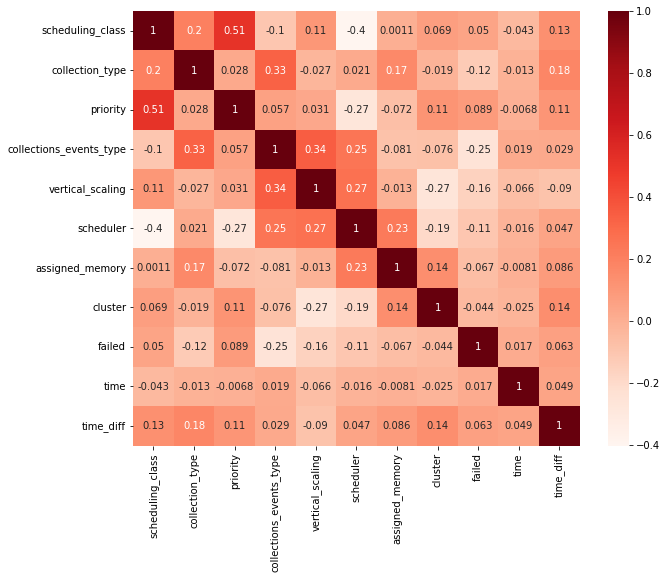

In [85]:
qML = qML.dropna()
ml_pandas = qML.toPandas()
corr = ml_pandas.corr()
fig = plt.figure(figsize = (10, 8))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [86]:
categorical_columns = ['scheduler','scheduling_class','collection_type','collections_events_type','cluster', 'vertical_scaling', 'time']

In [87]:
# The index of string values multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

In [88]:
# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]


In [89]:
f = [encoder.getOutputCol() for encoder in encoders]

In [90]:
f.append("priority")
f.append("assigned_memory")
f.append("time_diff")

In [91]:
# Vectorizing encoded values
assembler = VectorAssembler(inputCols=[c for c in f],outputCol="features")

pipeline = Pipeline(stages=indexers + encoders+[assembler])
model=pipeline.fit(qML)
transformed = model.transform(qML)
transformed.show(5)

22/12/23 01:17:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----------------+---------------+------------------+-----------------------+----------------+---------+--------------------+-------+--------+------+----+--------------------+-----------------+------------------------+-----------------------+-------------------------------+---------------+------------------------+------------+-------------------------+--------------------------------+-------------------------------+---------------------------------------+-----------------------+--------------------------------+--------------------+--------------------+
|scheduling_class|collection_type|          priority|collections_events_type|vertical_scaling|scheduler|     assigned_memory|cluster|   event|failed|time|           time_diff|scheduler_indexed|scheduling_class_indexed|collection_type_indexed|collections_events_

In [92]:
indexer = StringIndexer(inputCol="event", outputCol="eventIndex") 
indexed = indexer.fit(transformed).transform(transformed)

**Splitting data into Train and Test in 0.75 and 0.25 ratio respectively**

In [93]:
dfBinary = indexed.select("features", "failed")
dfMulti = indexed.select("features", "eventIndex")
dataBin = dfBinary.randomSplit([0.75, 0.25])
dataMulti = dfMulti.randomSplit([0.75, 0.25])

In [94]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'failed', maxIter=10)

In [95]:
lrModel = lr.fit(dataBin[0])

In [96]:
print("Logisitic Regression Model Training Accuracy on Binary Classification: {}% ".format(100*lrModel.summary.accuracy))

Logisitic Regression Model Training Accuracy on Binary Classification: 100.0% 


In [97]:
pred = lrModel.transform(dataBin[1])

In [98]:
pred.show(5)

+--------------------+------+--------------------+--------------------+----------+
|            features|failed|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(56,[0,2,6,8,18,2...|     0|[8.39587280932929...|[0.99977425366061...|       0.0|
|(56,[0,2,6,8,18,2...|     0|[8.39587280932929...|[0.99977425366061...|       0.0|
|(56,[0,2,6,8,18,2...|     0|[8.39587280932929...|[0.99977425366061...|       0.0|
|(56,[0,2,6,8,18,2...|     0|[8.39587280932929...|[0.99977425366061...|       0.0|
|(56,[0,2,6,8,18,2...|     0|[8.39587280932929...|[0.99977425366061...|       0.0|
+--------------------+------+--------------------+--------------------+----------+
only showing top 5 rows



In [105]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="failed")
print("Logisitic Regression Model Test Accuracy on Binary Classification: {}%".format(evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})*100))

Logisitic Regression Model Test Accuracy on Binary Classification: 100.0%


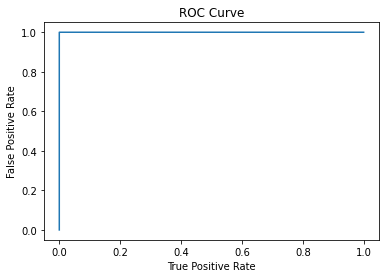

Training set areaUnderROC: 0.9999999960720636


In [100]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Q11) Multiclass Classification to see which event state will a request is more likely to go given its attributes like time, assigned memory etc? 

In [101]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'eventIndex', maxDepth = 3)
dtModel = dt.fit(dataMulti[0])

In [102]:
predictions = dtModel.transform(dataMulti[1])

In [104]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="eventIndex")
print("Decision Tree Test Accuracy: {}".format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})*100))

Decision Tree Test Accuracy: 79.601568052085


### ----------END---------- ###